#=
- Julia version: 1.10
- Author: Marcin Latawiec (311031)
- Date: 2024-06-13
=#

In [ ]:
include("../src/Graph.jl")
include("../src/DataModule.jl")
include("../src/UtilsModule.jl")
include("../src/AccuracyModule.jl")

In [16]:
using .DataModule, .UtilsModule, .AccuracyModule
using Random, Plots

In [17]:
function load_data(batch_size)
    println("Loading train data...")
    train_x, train_y = DataModule.preprocess(:train; one_hot = true)

    train_x_batched = DataModule.batch(train_x, batch_size)
    train_y_batched = DataModule.batch(train_y, batch_size)

    println("Loading test data...")
    test_x, test_y = DataModule.preprocess(:test; one_hot = true)
    return train_x, train_y, train_x_batched, train_y_batched, test_x, test_y
end

load_data (generic function with 1 method)

In [18]:
function update_weights!(graph::Vector, lr::Float64, batch_size::Int64)
    for node in graph
        if isa(node, Variable) && (node.name == "states" || node.name == "x")
                node.output = nothing
                node.gradient = nothing
        elseif isa(node, Variable) && hasproperty(node, :gradient) && node.gradient != nothing
#             println(string("Update ", node.name, " ", sum(node.output), " ", sum(node.gradient)))
#                 println(string("Sum1: ", node.name, " gradient: ", sum(node.gradient), " output ", sum(node.output)))
            node.gradient ./= batch_size
            node.output .-= lr * node.gradient
#                 println(string("Sum2: ", node.name, " gradient: ", sum(node.gradient), " output ", sum(node.output)))
            node.gradient .= 0
        end
    end
end

update_weights! (generic function with 1 method)

In [19]:
function reset_state!(graph::Vector)
    for node in graph
        if isa(node, Variable) && hasproperty(node, :gradient) && node.gradient != nothing
            node.gradient .= 0
        end
    end
end

reset_state! (generic function with 1 method)

In [20]:
function main()
    batch_size = 100
    train_x, train_y, train_x_batched, train_y_batched, test_x, test_y = load_data(batch_size)

    epochs = 5

    x = Variable([0.], name="x")
    y = Variable([0.], name="y")

    wd = Variable(UtilsModule.glorot_uniform(10, 64), name="wd")
    bd = Variable(UtilsModule.glorot_uniform(10, ), name="bd")

    wr = Variable(UtilsModule.glorot_uniform(64, 196), name = "wr")
    br = Variable(UtilsModule.glorot_uniform(64, ), name = "br")
    hwr = Variable(UtilsModule.glorot_uniform(64, 64), name = "hwr")
    states = Variable(nothing, name = "states")

    r = rnn_layer(x, wr, br, hwr, states)
    d = dense_layer(r, wd, bd)
    graph = topological_sort(d)

    # RNN cell per 196 pixels and then sum the results?

    batch_loss = Float64[]
    println("Training")
    for epoch in 1:epochs
        batches = randperm(size(train_x_batched, 1))
        @time for batch in batches
            reset_state!(graph)
            states.output = nothing
            y.output = train_y_batched[batch]
            x.output = train_x_batched[batch][  1:196,:]
            forward!(graph)

            x.output = train_x_batched[batch][197:392,:]
            forward!(graph)

            x.output = train_x_batched[batch][393:588,:]
            forward!(graph)

            x.output = train_x_batched[batch][589:end,:]
            result = forward!(graph)

            loss, acc, _ = AccuracyModule.loss_and_accuracy(result, train_y_batched[batch])
            push!(batch_loss, loss)
            gradient = AccuracyModule.get_gradient(result, y.output)
            backward!(graph, seed=gradient)
            # Update gradientu raczej na samym końcu jak w Fluxie
            update_weights!(graph, 15e-3, batch_size)
        end
        test_graph = topological_sort(d)

        y.output = test_y
        x.output = test_x[  1:196,:]
        reset_state!(test_graph)
        forward!(test_graph)

        x.output = test_x[197:392,:]
        forward!(test_graph)

        x.output = test_x[393:588,:]
        forward!(test_graph)

        x.output = test_x[589:end,:]
        result = forward!(test_graph)

        loss, acc, _ = AccuracyModule.loss_and_accuracy(result, test_y)

        states.output = zeros(Float32, size(x.output))
        @show epoch loss acc
    end
    plot(batch_loss, xlabel="Batch num", ylabel="loss", title="Loss over batches")
end

main (generic function with 1 method)

Loading train data...
Loading test data...
Training
  4.680986 seconds (7.04 M allocations: 1.539 GiB, 6.56% gc time, 55.61% compilation time)
epoch = 1
loss = 1.0891975f0
acc = 69.99
  2.030421 seconds (223.80 k allocations: 1.090 GiB, 4.18% gc time)
epoch = 2
loss = 0.7645076f0
acc = 78.38
  1.935831 seconds (223.80 k allocations: 1.090 GiB, 3.25% gc time)
epoch = 3
loss = 0.63562214f0
acc = 81.67
  1.941596 seconds (223.80 k allocations: 1.090 GiB, 3.28% gc time)
epoch = 4
loss = 0.5616285f0
acc = 83.84
  1.919981 seconds (223.80 k allocations: 1.090 GiB, 3.05% gc time)
epoch = 5
loss = 0.51082325f0
acc = 85.35


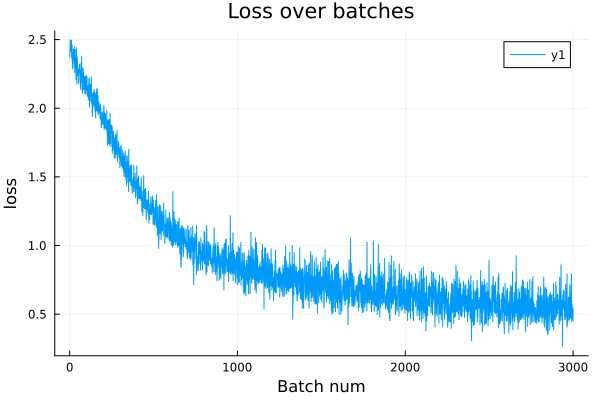

In [21]:
main()

In [ ]:
f